Đây là notebook chứa end-to-end pipeline

Mỗi notebook chỉ chứa 1 model thôi nhé

## Installations

## Data Preparation

Bước này đã được chuẩn bị ở notebook Data Preparation.

split_v3 https://drive.google.com/file/d/1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu/view?usp=drive_link

In [ ]:
# Download dataset
!gdown 1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu
!unzip splits_v3.zip

Streaming output truncated to the last 5000 lines.
  inflating: splits_v3/train/glass/glass_489.jpg  
  inflating: splits_v3/train/glass/glass_566.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2822_glass_19.jpg  
  inflating: splits_v3/train/glass/glass_591.jpg  
  inflating: splits_v3/train/glass/glass_616.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2816_glass_2.jpg  
  inflating: splits_v3/train/compost/compost_1276.jpg  
  inflating: splits_v3/train/glass/glass_574.jpg  
  inflating: splits_v3/train/compost/compost_1251.jpg  
  inflating: splits_v3/train/compost/compost_1212.jpg  
  inflating: splits_v3/train/compost/compost_1178.jpg  
  inflating: splits_v3/train/glass/glass_465.jpg  
  inflating: splits_v3/train/glass/glass_571.jpg  
  inflating: splits_v3/train/compost/compost_1173.jpg  
  inflating: splits_v3/train/compost/compost_1176.jpg  
  inflating: splits_v3/train/compost/compost_1190.jpg  
  inflating: splits_v3/train/glass/glass_499.jpg  
  inflating: s

### Load datasets

In [ ]:
TRAIN_PATH = '/content/splits_v3/train'
DEV_PATH = '/content/splits_v3/validation'
TEST_PATH = '/content/splits_v3/test'

https://medium0.com/@fromtheast/implement-fit-generator-in-keras-61aa2786ce98

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Data flow
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3260 images belonging to 7 classes.


In [ ]:
# Data generators
valid_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment valid set

valid_generator = valid_datagen.flow_from_directory(
    directory=DEV_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 699 images belonging to 7 classes.


In [ ]:

test_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment test set

test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 699 images belonging to 7 classes.


### Prepare

## Model Training

### Construct model

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

###### Transfer pretrained model

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = (256, 256, 3)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# freeze block5 in layer conv5
for layer in base_model.layers:
    if 'block5' in layer.name:
        layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
n_classes = 7

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation = 'softmax')
])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 23,468,551
Non-trainable params: 1,171,840
__________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 23,468,551
Non-trainable params: 1,171,840
__________________________________

In [ ]:
!nvidia-smi

Sun Jul  9 09:57:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    897MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Hyperparameter tuning (nếu cần)

### Train model

In [ ]:

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'resnet50_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
#help to solve gradient vanishing problem
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000000001)

In [ ]:
EPOCHS = 50
n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size

https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

`.fit()` nạp cả dataset vô RAM => ko đủ RAM để nạp nên dễ bị crash

`.fit_generator()`

In [ ]:
history = model.fit_generator(train_generator,
            epochs=EPOCHS,
            verbose=1,
            steps_per_epoch=n_train_steps, #batch_size,
            validation_data=valid_generator,
            validation_steps=n_valid_steps,
            callbacks = [tl_checkpoint_1, early_stop, rop_callback])

<ipython-input-32-ba8a1dd06835>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
101/101 [==============================] - 139s 847ms/step - loss: 1.6114 - accuracy: 0.4349 - val_loss: 3.3636 - val_accuracy: 0.1443 - lr: 0.0010
Epoch 2/50
101/101 [==============================] - 70s 684ms/step - loss: 1.2258 - accuracy: 0.5620 - val_loss: 2.1812 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 3/50
101/101 [==============================] - 71s 703ms/step - loss: 1.0583 - accuracy: 0.6255 - val_loss: 3.7382 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 4/50
101/101 [==============================] - 69s 681ms/step - loss: 0.9573 - accuracy: 0.6530 - val_loss: 4.5250 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 5/50
101/101 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.6877
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
101/101 [==============================] - 70s 695ms/step - loss: 0.8761 - accuracy: 0.6877 - val_loss: 3.7494 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 6/50
101/101 [============================

## Model Analysis


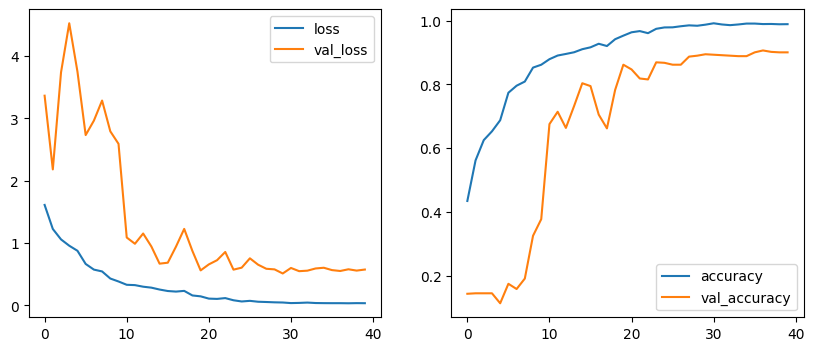

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
y_predict=model.predict(test_generator)

699/699 [==============================] - 8s 10ms/step


In [ ]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [ ]:
labels = test_generator.labels

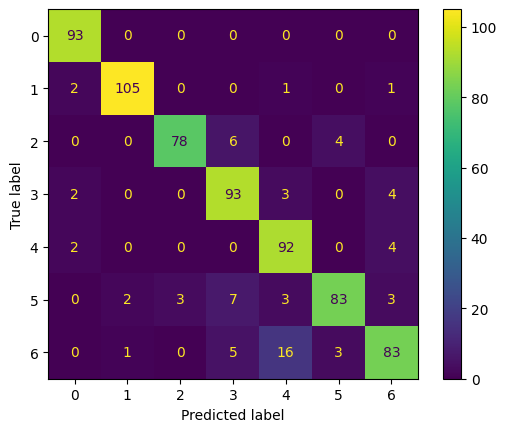

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
target_names = list(test_generator.class_indices.keys())

In [ ]:
target_names

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.94      1.00      0.97        93
     compost       0.97      0.96      0.97       109
       glass       0.96      0.89      0.92        88
       metal       0.84      0.91      0.87       102
       paper       0.80      0.94      0.86        98
     plastic       0.92      0.82      0.87       101
       trash       0.87      0.77      0.82       108

    accuracy                           0.90       699
   macro avg       0.90      0.90      0.90       699
weighted avg       0.90      0.90      0.90       699



## Save model

Sau khi save xong hãy tải xuống và up lên drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!mkdir pretrained_models

In [ ]:
%cd pretrained_models

/content/drive/MyDrive/pretrained_models


In [ ]:
model.save('ResNet')

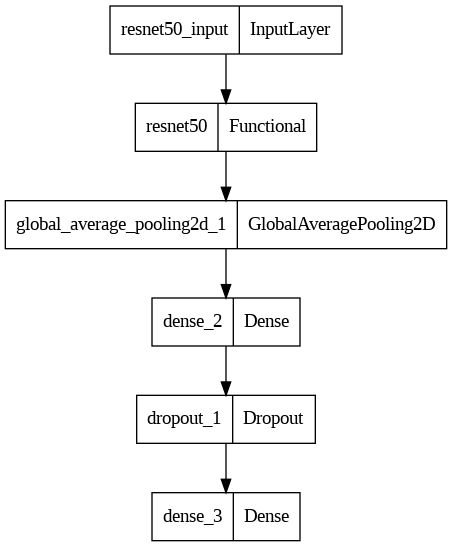

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)